## Set Up

In [1]:
# !/usr/env python3

'''
Output:
video captioning model itself and produce loss curve

Usage:
main document to train the video captioning model
'''

# set up
from __future__ import print_function
import tensorflow as tf
import pickle
import os
import numpy as np
import logging
import matplotlib.pyplot as plt
from util import *
from model.video_caption import sequence_2_sequence_LSTM
from load_caption_feature import *
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import gc
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Process and save data  
Load caption Xtrain, Xtest, ytrain, ytest, video_train, video_test and save them.  
Here in details, see **load_caption_feature.py**. Only need to run once, codes are going to save the data file. 

In [2]:
# load and save training data
num_frames = 15
size = (224, 224, 3)

# more balanced data
idx_path = os.getcwd() + '/datasets/x_train_ind_above400.npy'
Xtrain_idx = np.load(idx_path)
labels = np.load(os.getcwd() + '/datasets/y_train_mapped_above400.npy')

# if all videos then 
num_videos = len(Xtrain_idx)

tic = datetime.now()
# for clearing memory convenience
model = vgg_16_pretrained()
Xtr, ytr = load_features(model, num_videos, num_frames, Xtrain_idx, labels, size = (224, 224, 3), train_test_flag='train')

KeyboardInterrupt: 

In [ ]:
# clear memory
del Xtr
del ytr
model = None
gc.collect()

In [ ]:
# load and save test data
num_frames_test = 15
size = (224, 224, 3)

# more balanced data
idx_path = os.getcwd() + '/datasets/x_test_ind_above400.npy'
Xtest_idx = np.load(idx_path)
ytest = np.load(os.getcwd() + '/datasets/y_test_mapped_above400.npy')

# if all videos then 
num_videos_test = len(Xtest_idx)

model = vgg_16_pretrained()
Xte, yte = load_features(model, num_videos_test, num_frames_test, Xtest_idx, ytest, size = (224, 224, 3), train_test_flag='test')

In [ ]:
# clean memory
del Xte
del yte
model = None
gc.collect()

In [ ]:
# save input frames train and test
curr = os.getcwd() + '/datasets'
def save_frames(X, vid_ls, mode = 'train'):
    X = X.reshape((-1, 15, 4096))
    assert X.shape[0] == len(vid_ls)
    input_frames = {}
    for i in range(X.shape[0]):
        vid = vid_ls[i]
        input_frames[vid] = X[i]
    pickle.dump(input_frames, open(curr + '/input_frames_' + mode + '.pickle', 'wb'))

vid_train = np.load(curr + '/videoIdtrain_allCap_15frames.npy')
Xtr = np.load(curr + '/Xtrain_allCap_15frames.npy')
Xte = np.load(curr + '/Xtest_allCap_15frames.npy')
vid_test = np.load(curr + '/videoIdtest_allCap_15frames.npy')
save_frames(Xtr, vid_train, mode = 'train')
save_frames(Xte, vid_test, mode = 'test')

## Model setup and train

### Model Configuration and Parameters 
Parameters:  

* model_name: the name of model, here we refer sequence to sequence model from [1](https://arxiv.org/abs/1505.00487);  
* state_size: lstm encoder and encoder state dimension  
* learning_rate: learning rate  
* input_size: vector size input to lstm, here we use pretrained VGG16 output 4096 dimension  
* batch_size: batch size  
* max_sentence_length: fixed length for captions, default is 20 
* word_vector_size: depends on vocabulary chosen, here is 50, but can be changed 
* voc_size: depends on vocabulary created, if self-created vocabulary, it is 6169, if glove
* n_epoches: the number of epoches to run  
* num_frames: frame number  
* hidden_size: lstm encoder and encoder hidden dimension 

**Reference**  
[1] Venugopalan, S., Rohrbach, M., Donahue, J., Mooney, R., Darrell, T., & Saenko, K. (2015). Sequence to sequence-video to text. In Proceedings of the IEEE International Conference on Computer Vision (pp. 4534-4542).  

In [2]:
# define parameters

logging.basicConfig(level=logging.INFO)
#=======Change These===============================
tf.app.flags.DEFINE_string("model_name", "sequence2sequence", "name of the model")
tf.app.flags.DEFINE_integer("state_size", 100, "Size of each model layer.")
#==================================================

tf.app.flags.DEFINE_float("input_size", 4096, "input size for each frame")
tf.app.flags.DEFINE_integer("max_sentence_length", 20, "maximum captioning sentence length")
tf.app.flags.DEFINE_integer("word_vector_size", 50, "word embedding dimension default is 25 for twitter glove")
tf.app.flags.DEFINE_integer("num_frames", 15, "number of frames per video")
FLAGS = tf.app.flags.FLAGS        

### Load Training Data

In [3]:
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

curPath = os.getcwd()
dataPath = curPath + "/datasets/"

# pick first 100 for debugging purpose
# load data
sample_size = 500
wvector_dim = 50
is_training = True
input_frames_train, captions_train, \
        word_dict, word2Index, index2Word = load_caption_data(sample_size, dataPath, train = is_training)
word_embedding = word_embedding_array(word_dict, wvector_dim, word2Index) 
print('Finish loading training data!')

Finish loading training data!


### Build Model Graph  
In details, see **model/video_caption.py**.   
We refer to sequence to sequence model to build two LSTM layers. One is encoder, and the other is decoder. The cell number of decoder depends on the maximum caption length we set. Here we choose 20 here by exploring the distribution of captions. In order to make encoder have same length of outputs, we add pad cells to encoder. Encoder accept 15 frames VGG16 outputs so that it has 15 cells. 

In [24]:
# build model graph
tf.reset_default_graph()

lr = 1e-3
hidden_size = 1024
state_size = 1024
batch_size = 64
voc_size = 6169
epoch = 7

model = sequence_2_sequence_LSTM(word_embedding, FLAGS, batch_size=batch_size, hidden_size=hidden_size,
        voc_size = voc_size, n_epochs = epoch, lr = lr, reg = 1e-4, mode = 'train', save_model_file = 'bestModel')
model.train_embedding = True
model.build()

start building model ...
total number of parameter 36217083


In [13]:
# check variables
for v in tf.trainable_variables():
    print(v)

<tf.Variable 'embeddings/embeddings:0' shape=(6169, 50) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/encoder/layer_norm_basic_lstm_cell/weights:0' shape=(5120, 4096) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/encoder/layer_norm_basic_lstm_cell/input/gamma:0' shape=(1024,) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/encoder/layer_norm_basic_lstm_cell/input/beta:0' shape=(1024,) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/encoder/layer_norm_basic_lstm_cell/transform/gamma:0' shape=(1024,) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/encoder/layer_norm_basic_lstm_cell/transform/beta:0' shape=(1024,) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/encoder/layer_norm_basic_lstm_cell/forget/gamma:0' shape=(1024,) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/encoder/layer_norm_basic_lstm_cell/forget/beta:0' shape=(1024,) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/encoder/layer_norm_basic_lstm_cell/output/gamma:0' shape=(1024,) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/encoder/l

### Training 

4270
3416
55/53 [===============================] - 56s - train loss: 5.5125


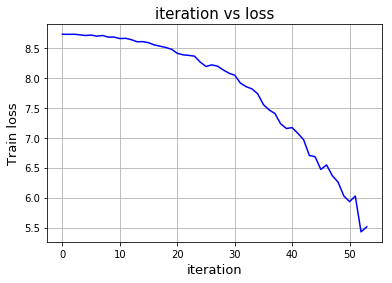

1/7 [===>..........................] - ETA: 377s - train loss: 7.7937 - dev loss: 5.3232 
Validation loss improved, Save Model!
55/53 [===============================] - 53s - train loss: 3.8959


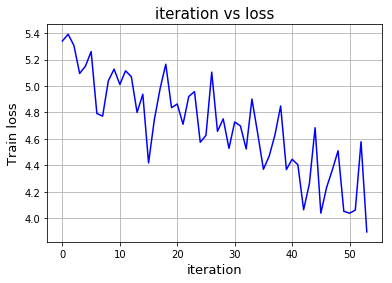

2/7 [=======>......................] - ETA: 304s - train loss: 4.7008 - dev loss: 4.0627 
Validation loss improved, Save Model!
55/53 [===============================] - 53s - train loss: 3.4363


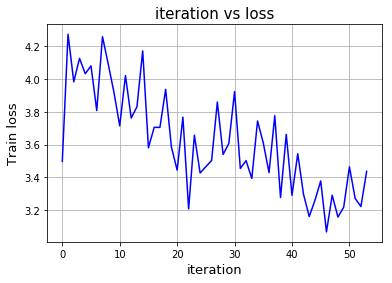

3/7 [===========>..................] - ETA: 240s - train loss: 3.6179 - dev loss: 3.1491 
Validation loss improved, Save Model!
55/53 [===============================] - 53s - train loss: 2.1749


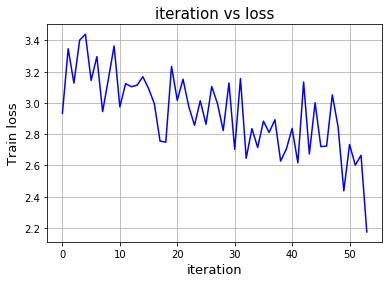

4/7 [================>.............] - ETA: 179s - train loss: 2.9370 - dev loss: 2.6532 
Validation loss improved, Save Model!
55/53 [===============================] - 53s - train loss: 2.3503


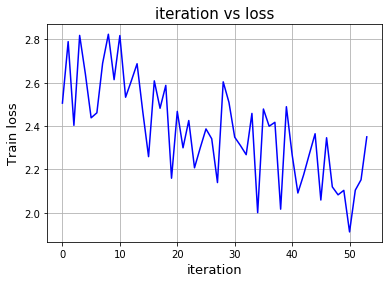

5/7 [====================>.........] - ETA: 118s - train loss: 2.3826 - dev loss: 2.0691 
Validation loss improved, Save Model!
55/53 [===============================] - 53s - train loss: 1.3173


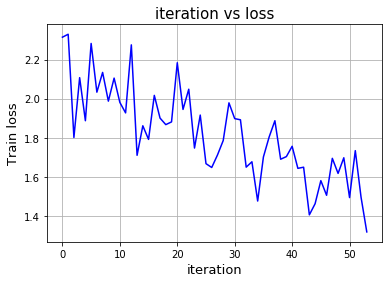

6/7 [========================>.....] - ETA: 59s - train loss: 1.8192 - dev loss: 1.5589  
Validation loss improved, Save Model!
55/53 [===============================] - 53s - train loss: 0.8515


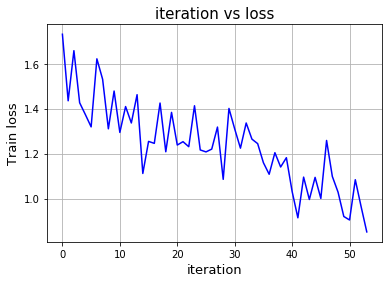

7/7 [==============================] - 414s - train loss: 1.2409 - dev loss: 1.0705    
 
Validation loss improved, Save Model!


In [25]:
# run training mode
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    out = model.train(sess, (input_frames_train, captions_train), verbose = True)

In [26]:
# unpack
val_loss, tr_loss, tr_pred, val_pred, train_vid, val_vid = out

### Plot Learning Curves

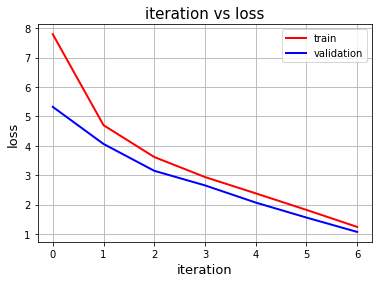

In [27]:
# plot learning curve
plt.plot(range(len(tr_loss)), tr_loss, 'r-', linewidth = 2, label = 'train')
plt.plot(range(len(val_loss)), val_loss, 'b-', linewidth = 2, label = 'validation')
plt.grid()
plt.xlabel('iteration', fontsize = 13)
plt.ylabel('loss', fontsize = 13)
plt.title('iteration vs loss', fontsize = 15)
plt.legend()
plt.savefig(os.getcwd() + '/output/caption_learning_curve.png')

### Check batch captions

In [ ]:
# check captions
sample_size = 100
wvector_dim = 50
is_training = False
input_frames_test, captions_test = load_caption_data(sample_size, dataPath, train = is_training)
model.mode = 'test'
with get_session() as sess:
    saver = tf.train.Saver()
    # saver.restore(sess, os.getcwd() + "/model/bestModel.ckpt")
    out = model.predict(sess, (input_frames_test, captions_test))

In [28]:
# list_video_index, list_predict_index = out
# captions = {k: v for k, v in captions_test}
captions = captions_train

pred = val_pred
captions_pred = {}
captions_true = {}

# caption check
for j, vid in enumerate(val_vid):
    words = []
    trues = []
    sample = val_pred[j]
    cap = captions[vid]
    for idx, i in enumerate(sample):
        word = index2Word[i]
        true = index2Word[cap[idx]]
        if word not in ['<START>', '<END>', '<pad>']:
            words.append(word)
        if true not in ['<START>', '<END>', '<pad>']:
            trues.append(true)   
            
    captions_pred[vid] = ' '.join(w for w in words)
    captions_true[vid] = ' '.join(t for t in trues)
    print(vid)
    print('Pred Caption: ', ' '.join(w for w in words))
    print('True Caption: ', ' '.join(t for t in trues))
    print('-'*50)

4760.0
Pred Caption:  kiss out out in an how
True Caption:  kiss get stuck in unusual ways
--------------------------------------------------
9299.0
Pred Caption:  black dog very talking to how person inside camera
True Caption:  black dog very excited to see person behind camera
--------------------------------------------------
9192.0
Pred Caption:  a person is shown how a paper of water
True Caption:  a person is shown getting a glass of water
--------------------------------------------------
4269.0
Pred Caption:  a man forage using food
True Caption:  a man draining transmission oil
--------------------------------------------------
526.0
Pred Caption:  person is in the race with other other of the football
True Caption:  person is in the formula with other members of the team
--------------------------------------------------
7942.0
Pred Caption:  three three wresting for on it very show play with football clips
True Caption:  top ten moves based on real life events starting with

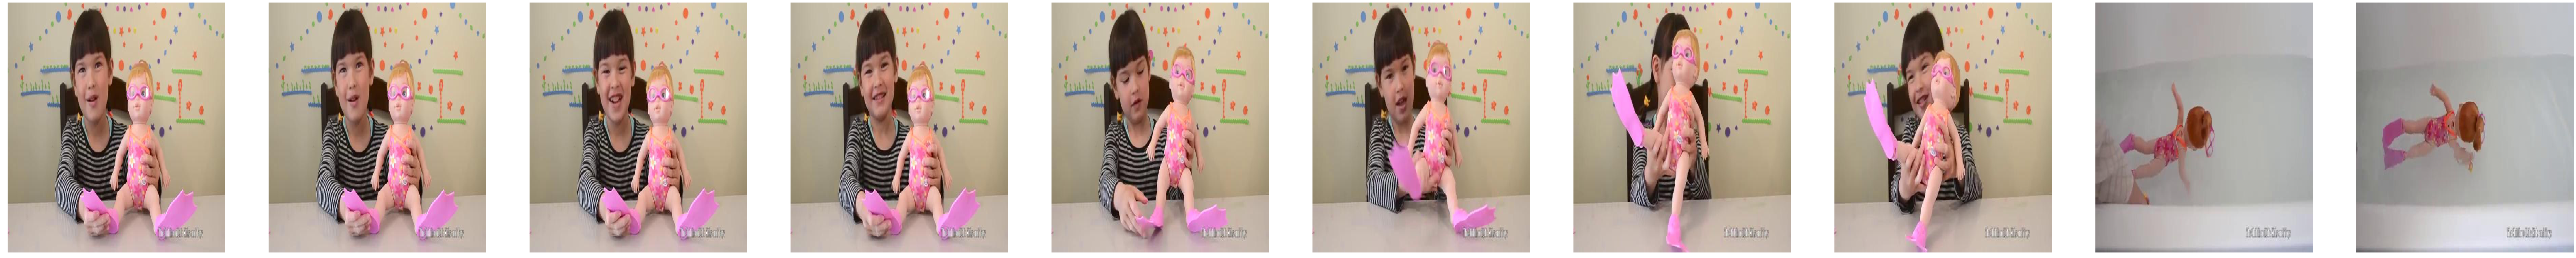

Pred Caption:  a child shows a toy
True Caption:  a child shows a doll


In [30]:
vid = 2989.0

num_frames = 10
plt.figure(figsize=(200,20))
for j in range(num_frames):
    plt.subplot(1, num_frames, j+1)
    framePath = os.getcwd() + "/datasets/frames/video" + str(int(vid)) + "/frame" + str(j+1) + '.jpg'
    image = mpimg.imread(framePath)
    plt.imshow(image,aspect='auto')
    plt.axis('off')
plt.show()
print('Pred Caption: ', captions_pred[vid])
print('True Caption: ',captions_true[vid])

### Test Prediction and Evaluation